        E:\Data\FinalResults\Dsp\0854 - Manifold of Initialization Revisit is already existed!


100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


(280,)


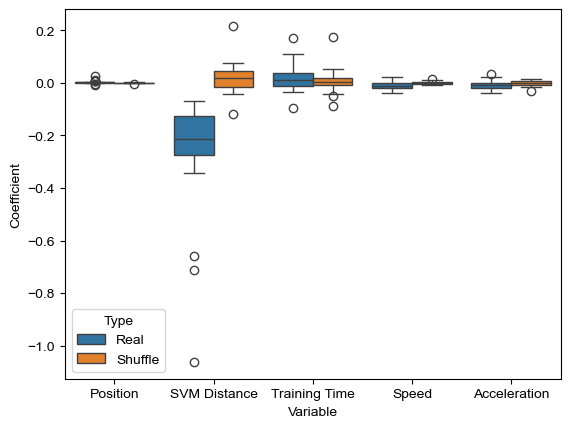

Acceleration: 
  P-value with 0:        0.020451
  P-value within Class:  0.049141
Position: 
  P-value with 0:        0.019648
  P-value within Class:  0.010074
SVM Distance: 
  P-value with 0:        0.000001
  P-value within Class:  0.000003
Speed: 
  P-value with 0:        0.001015
  P-value within Class:  0.002342
Training Time: 
  P-value with 0:        0.083221
  P-value within Class:  0.339550


In [8]:
from mylib.statistic_test import *
from scipy.ndimage import gaussian_filter
import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian
from sklearn.model_selection import KFold

code_id = "0854 - Manifold of Initialization Revisit"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_transient_map(mouse: int):
    if exists(join(loc, f"transient_{mouse} .pkl")):
        with open(join(loc, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    else:
        with open(join(dir_name0, f"{mouse}.pkl"), 'rb') as handle:
            (
                map_clusters, 
                session_traj, 
                dist_clusters, # Normalized Distances.
                dists, 
                route_traj, 
                lap_traj, 
                pos_traj, 
                speed_traj, 
                beg, end, 
                reduced_data, 
                centroid, 
                raddi, 
                neural_traj
            ) = pickle.load(handle)
            
        idx = np.where(np.isin(
            pos_traj+1,
            np.concatenate([Father2SonGraph[i] for i in CP_DSP[0]])
        ))
        
        norm_dist_traj = dist_clusters
        with open(join(loc, f"transient_{mouse}.pkl"), 'wb') as f:
            pickle.dump([
                map_clusters[idx],
                norm_dist_traj[idx],
                dists[idx],
                route_traj[idx],
                lap_traj[idx],
                session_traj[idx],
                pos_traj[idx],
                speed_traj[idx],
                centroid,
                raddi,
                neural_traj[:, idx]
            ], f)
            
        return (
            map_clusters[idx],
            norm_dist_traj[idx],
            dists[idx],
            route_traj[idx],
            lap_traj[idx],
            session_traj[idx],
            pos_traj[idx],
            speed_traj[idx],
            centroid,
            raddi,
            neural_traj[:, idx]
        )

def fit_glm(mouse, route, session = None, is_shuffle: bool = False):
    (
        map_clusters,
        norm_dist_traj,
        dists,
        route_traj,
        lap_traj,
        session_traj,
        pos_traj,
        speed_traj,
        centroid,
        raddi,
        neural_traj
    ) = get_transient_map(mouse)

    idx = np.where((route_traj[:-1] == route)&(np.ediff1d(lap_traj) == 0))[0]
    
    dy = np.ediff1d(norm_dist_traj)[idx][:, np.newaxis]
    dy = (dy - np.mean(dy)) / np.std(dy)
    if is_shuffle:
        dy = np.roll(dy, np.random.randint(dy.shape[0]))
    
    data = {
        "Position": dists[:-1][idx],
        "SVM Distance": norm_dist_traj[:-1][idx],
        "Training Time": session_traj[:-1][idx],
        "Speed": speed_traj[:-1][idx],
        "Acceleration": np.ediff1d(speed_traj)[idx],
    }
    
    D = pd.DataFrame(data)
    X = D
    #X = sm.add_constant(D)
    
    # Define KFold cross-validation (e.g., 5 folds)
    avg_coeffs = {col: [] for col in X.columns}
    
    for iter in range(10):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X, dy):
            # Split data
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = dy[train_index, :], dy[test_index, :]    
            # Fit GLM model
            model = sm.GLM(y_train, X_train, family=Gaussian())
            model_results = model.fit()
    
            # Store the coefficients
            for col in X_train.columns:
                avg_coeffs[col].append(model_results.params[col])
            
    # Average coefficients across all folds
    avg_coefficients = {col: np.mean(coeffs) for col, coeffs in avg_coeffs.items()}
    return np.array([avg_coefficients[k] for k in avg_coefficients.keys()])

if exists(join(figdata, code_id+" .pkl")) == False:
    Data = {
        "MiceID": [],
        "Route": [],
        "Variable": [],
        "Coefficient": [],
        "Type": []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in tqdm(range(7)):
            for is_shuffle in [False, True]:    
                res = fit_glm(mouse, s, is_shuffle=is_shuffle)
                Data['MiceID'].append(np.repeat(mouse, 5))
                Data['Route'].append(np.repeat(s, 5))
                Data['Variable'].append(np.array([
                    #'Constant', 
                    'Position',
                    'SVM Distance',
                    'Training Time',
                    'Speed',
                    'Acceleration'
                ]))
                Data['Coefficient'].append(res)
                categories = "Real" if is_shuffle == False else "Shuffle"
                Data['Type'].append(np.repeat(categories, 5))
    
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
    
    print(Data['Coefficient'].shape)
    with open(join(figdata, f'{code_id}.pkl'), 'wb') as f:
        pickle.dump(Data, f)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id}.xlsx"), index=False)
else:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)
        
sns.boxplot(
    x='Variable',
    y='Coefficient',
    data=Data,
    hue='Type'
)
plt.show()

for k in np.unique(Data['Variable']):
    res1samp = ttest_1samp(Data['Coefficient'][np.where(
        (Data['Variable'] == k) &
        (Data['Type'] == 'Real')
    )[0]], 0)[1]
    
    respaired = ttest_rel(
        Data['Coefficient'][np.where(
            (Data['Variable'] == k) &
            (Data['Type'] == 'Real')
        )[0]],
        Data['Coefficient'][np.where(
            (Data['Variable'] == k) &
            (Data['Type'] == 'Shuffle')
        )[0]]
    )[1]
    print(f"{k}: \n  P-value with 0:        {res1samp:.6f}")
    print(f"  P-value within Class:  {respaired:.6f}")